In [1]:
!pip -q install -U scikit-learn

In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')


# Replace the path the actual folder name
os.chdir('/content/drive/MyDrive/DSO 585')

# Confirm that the files are accessible
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['bank-full.csv',
 'bank-additional-full.csv',
 'Team 10 - Predicting and Understanding Customer Subscription Decisions in Banking Campaigns.docx',
 'Week 3 - Data Cleaning & EDA',
 'Week 4 - Predictive Model',
 'Week 5',
 'Week 6 - Uplift (Telephone)',
 'Week 7 - Weighting',
 'Week 8 - Uplifting Model',
 'catboost_info',
 'DSO585 Causal Inference - Single Contact.ipynb',
 'Final',
 'DSO585 Causal Inference - Contact V1.ipynb',
 'DSO585 Causal Inference - Single Contact - Heterogeneous Effects.ipynb']

In [3]:
import pandas as pd
df = pd.read_csv('bank-full.csv', sep=";")
df.head(10)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [4]:
df.shape

(45211, 17)

# **Missing Values / Unknown Values**

In the dataset, several categorical variables contain "unknown" entries. To ensure data quality while minimizing bias:



1.   Job (0.8%), Marital (0.2%), Education (4.2%): Rows with "unknown" were dropped, since the share of missing values was small (<5%) and these demographic features are important for interpretation. Retaining "unknown" as a category would add noise rather than meaningful signal.
2.   Housing (2.4%), Loan (2.4%), Default (20.9%): "Unknown" values were retained as their own category. Dropping them would lead to substantial data loss (especially for default), and "unknown" may itself carry predictive information about customer behavior.
3.  Duration: Dropped entirely due to data leakage, as it is only known after the marketing call is completed.

In [5]:
# Missing value
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [6]:
for col in df.columns:
    unknown_count = (df[col] == 'unknown').sum()
    total_count = len(df[col])
    unknown_percentage = (unknown_count / total_count) * 100 if total_count > 0 else 0
    print(f"Column '{col}': {unknown_count} unknown values ({unknown_percentage:.2f}%)")

Column 'age': 0 unknown values (0.00%)
Column 'job': 288 unknown values (0.64%)
Column 'marital': 0 unknown values (0.00%)
Column 'education': 1857 unknown values (4.11%)
Column 'default': 0 unknown values (0.00%)
Column 'balance': 0 unknown values (0.00%)
Column 'housing': 0 unknown values (0.00%)
Column 'loan': 0 unknown values (0.00%)
Column 'contact': 13020 unknown values (28.80%)
Column 'day': 0 unknown values (0.00%)
Column 'month': 0 unknown values (0.00%)
Column 'duration': 0 unknown values (0.00%)
Column 'campaign': 0 unknown values (0.00%)
Column 'pdays': 0 unknown values (0.00%)
Column 'previous': 0 unknown values (0.00%)
Column 'poutcome': 36959 unknown values (81.75%)
Column 'y': 0 unknown values (0.00%)


In [7]:
# Drop leakage column
df = df.drop(columns=['duration'])

# Define target variable
y = df['y'].map({'yes': 1, 'no': 0})
X = df.drop(columns=['y'])

/tmp/ipython-input-2259418136.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='y', data=df, palette='viridis', order=['no', 'yes'])


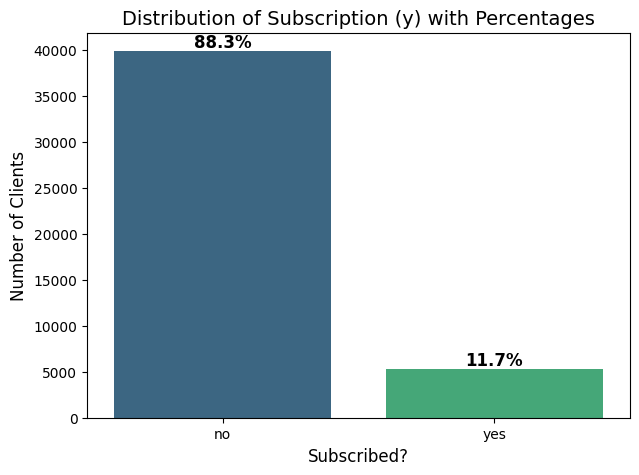

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the figure size
plt.figure(figsize=(7, 5))

# Create the countplot
# We define the order explicitly to ensure consistency
ax = sns.countplot(x='y', data=df, palette='viridis', order=['no', 'yes'])

# Calculate the total number of entries
total = len(df['y'])

# Iterate through the bars (patches) to add text
for p in ax.patches:
    # Calculate percentage
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)

    # Get coordinates for the text
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()

    # Annotate the bar
    ax.annotate(percentage, (x, y), ha='center', va='bottom',
                fontsize=12, fontweight='bold', color='black')

plt.title('Distribution of Subscription (y) with Percentages', fontsize=14)
plt.xlabel('Subscribed?', fontsize=12)
plt.ylabel('Number of Clients', fontsize=12)
plt.show()

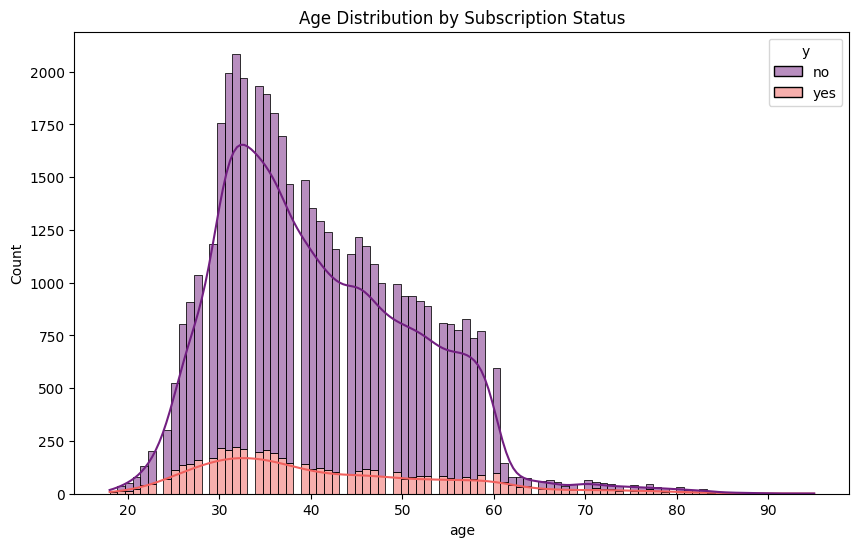

In [9]:
# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='y', multiple="stack", palette='magma', kde=True)
plt.title('Age Distribution by Subscription Status')
plt.show()

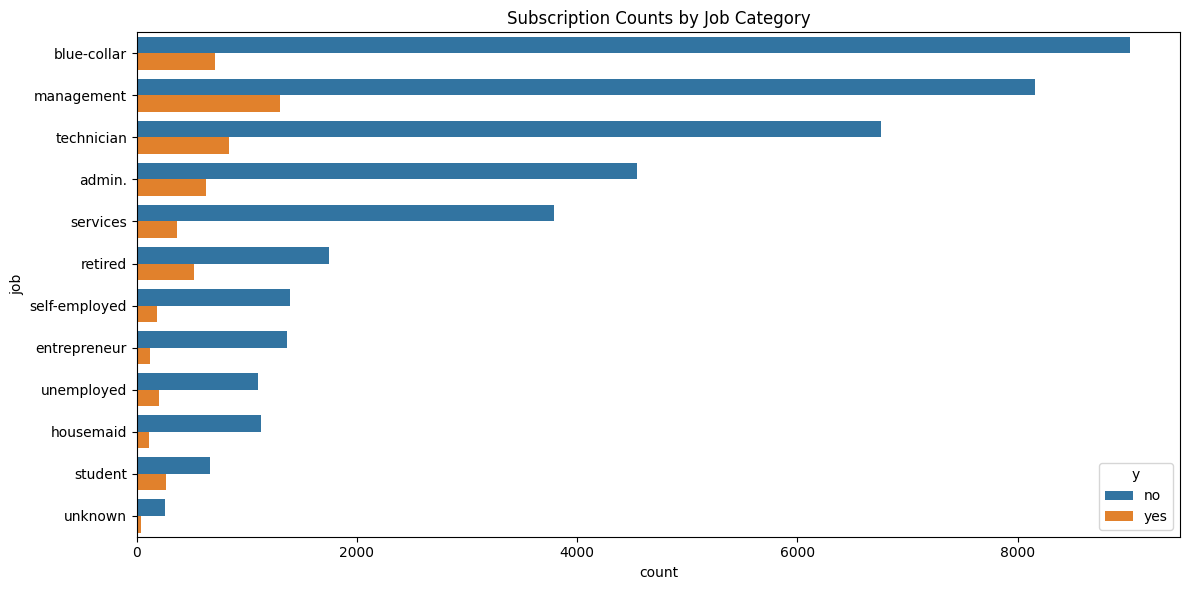

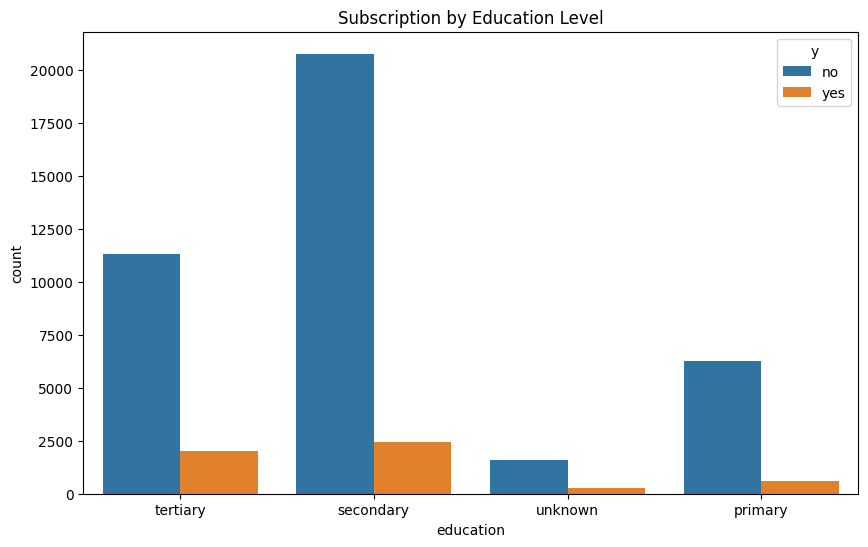

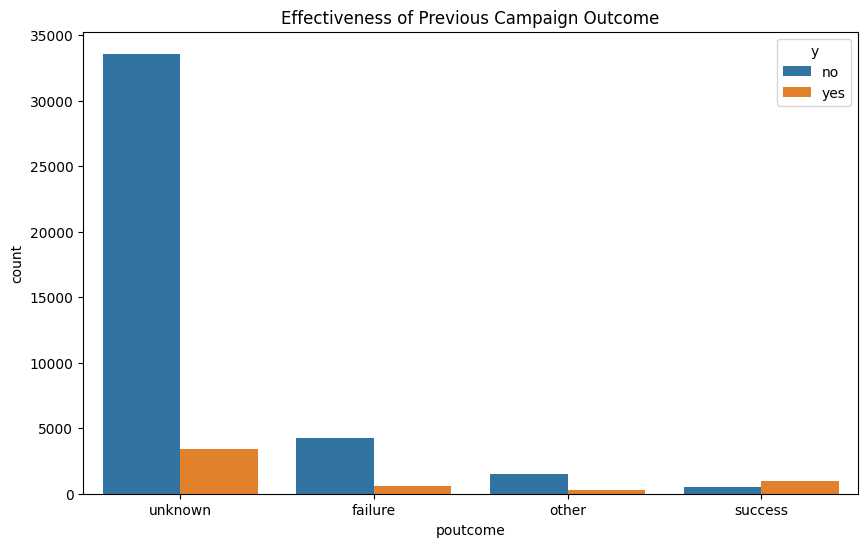

In [10]:
# Job vs Subscription
plt.figure(figsize=(12, 6))
sns.countplot(y='job', hue='y', data=df, order=df['job'].value_counts().index)
plt.title('Subscription Counts by Job Category')
plt.tight_layout()
plt.show()

# Education Level vs Subscription
plt.figure(figsize=(10, 6))
sns.countplot(x='education', hue='y', data=df)
plt.title('Subscription by Education Level')
plt.show()

# Previous Marketing Outcome vs Subscription
plt.figure(figsize=(10, 6))
sns.countplot(x='poutcome', hue='y', data=df)
plt.title('Effectiveness of Previous Campaign Outcome')
plt.show()

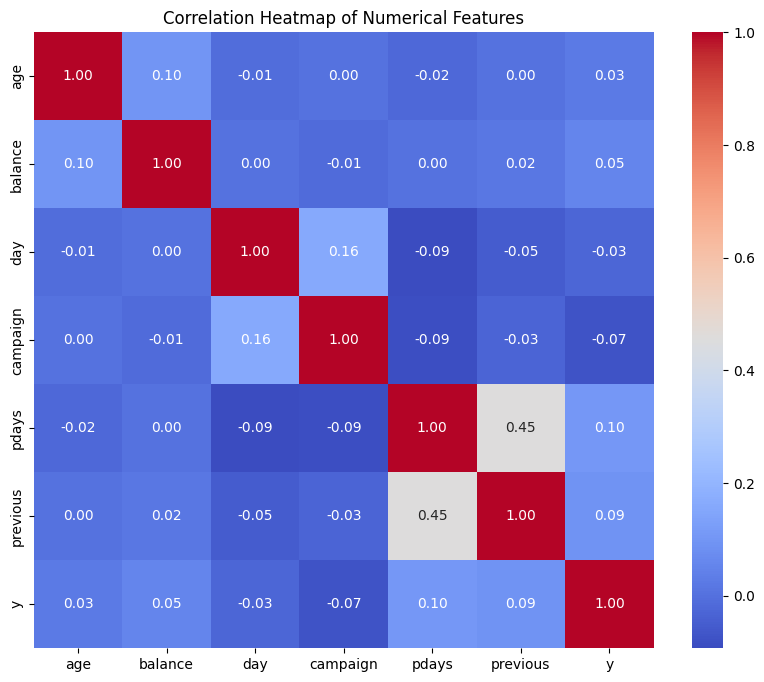

In [11]:
df_corr = df.copy()
df_corr['y'] = df_corr['y'].map({'yes': 1, 'no': 0})
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.select_dtypes(include=['int64', 'float64']).corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [12]:
print("--- Descriptive Statistics ---")
print(df.describe())

print("\n--- Subscription Rates by Category ---")
# Calculating the percentage of 'yes' for specific categories
print("\nMean Balance per Class:")
print(df.groupby('y')[['balance']].mean())

print("\nSubscription Rate by Housing Loan:")
print(df.groupby('housing')['y'].value_counts(normalize=True).unstack())

--- Descriptive Statistics ---
                age        balance           day      campaign         pdays  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419      2.763841     40.197828   
std       10.618762    3044.765829      8.322476      3.098021    100.128746   
min       18.000000   -8019.000000      1.000000      1.000000     -1.000000   
25%       33.000000      72.000000      8.000000      1.000000     -1.000000   
50%       39.000000     448.000000     16.000000      2.000000     -1.000000   
75%       48.000000    1428.000000     21.000000      3.000000     -1.000000   
max       95.000000  102127.000000     31.000000     63.000000    871.000000   

           previous  
count  45211.000000  
mean       0.580323  
std        2.303441  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  

--- Subscription Rates by Category ---

Mean Bala

# **Encoding**

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
data = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  45211 non-null  int64 
 1   balance              45211 non-null  int64 
 2   day                  45211 non-null  int64 
 3   campaign             45211 non-null  int64 
 4   pdays                45211 non-null  int64 
 5   previous             45211 non-null  int64 
 6   y                    45211 non-null  object
 7   job_blue-collar      45211 non-null  bool  
 8   job_entrepreneur     45211 non-null  bool  
 9   job_housemaid        45211 non-null  bool  
 10  job_management       45211 non-null  bool  
 11  job_retired          45211 non-null  bool  
 12  job_self-employed    45211 non-null  bool  
 13  job_services         45211 non-null  bool  
 14  job_student          45211 non-null  bool  
 15  job_technician       45211 non-null  bool  
 16  job_

In [15]:
data[data["contact_unknown"]==1].describe()

,age,balance,day,campaign,pdays,previous
count,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000
mean,40.600077,1183.550384,15.360138,2.787481,1.299386,0.021966
std,9.439221,2638.647690,8.454077,3.371954,36.451647,0.502526
min,20.000000,-3372.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,50.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,389.000000,15.000000,2.000000,-1.000000,0.000000
75%,48.000000,1255.250000,21.000000,3.000000,-1.000000,0.000000
max,61.000000,58544.000000,31.000000,63.000000,850.000000,41.000000


# **Baseline Model - Logistic Regression**

Confusion Matrix:
 [[6171 1814]
 [ 398  660]]

Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.77      0.85      7985
         yes       0.27      0.62      0.37      1058

    accuracy                           0.76      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.76      0.79      9043


ROC-AUC Score: 0.7721050694058923


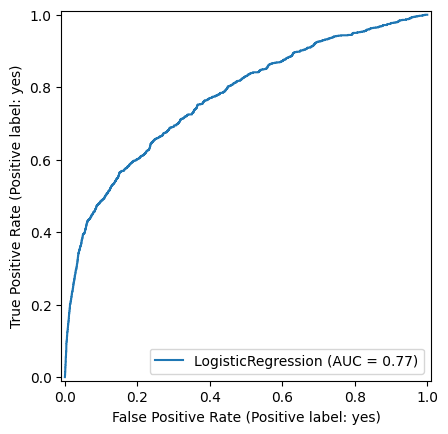

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
X = data.drop('y', axis=1)
y = data['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
numeric_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

# Fit and transform the training data, only transform the test data
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Train logistic regression
log_reg = LogisticRegression(max_iter=500, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Plot ROC curve
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Assuming log_reg is the LogisticRegression model trained earlier (cell MrvpiIiQ8H3Y)
# X_train and y_train are the scaled training data for this model.

# Initialize StratifiedKFold for 5-fold cross-validation
stratified_kfold_lr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get ROC-AUC scores
lr_roc_auc_scores = cross_val_score(
    log_reg,            # The baseline Logistic Regression classifier
    X_train,            # Scaled X_train from LR section
    y_train,            # y_train from LR section (original labels 'yes'/'no')
    cv=stratified_kfold_lr,
    scoring='roc_auc',
    n_jobs=-1           # Use all available CPU cores
)

print(f"Logistic Regression ROC-AUC scores for each fold: {lr_roc_auc_scores}")
print(f"Mean Logistic Regression ROC-AUC: {np.mean(lr_roc_auc_scores):.3f}")
print(f"Standard Deviation of Logistic Regression ROC-AUC: {np.std(lr_roc_auc_scores):.3f}")

Logistic Regression ROC-AUC scores for each fold: [0.76404987 0.7652406  0.7590614  0.7683341  0.76158483]
Mean Logistic Regression ROC-AUC: 0.764
Standard Deviation of Logistic Regression ROC-AUC: 0.003


Lasso

In [18]:
from sklearn.linear_model import LogisticRegressionCV

# Logistic Regression with L1 penalty (Lasso), using cross-validation
lasso_log_reg = LogisticRegressionCV(
    Cs=10,  # number of inverse regularization strengths to try
    cv=5,   # 5-fold cross-validation
    penalty='l1',
    solver='liblinear',  # L1 requires liblinear or saga
    scoring='roc_auc',
    class_weight='balanced',
    max_iter=1000
)

lasso_log_reg.fit(X_train, y_train)

print("Best C (inverse of regularization strength):", lasso_log_reg.C_[0])
print("ROC-AUC:", roc_auc_score(y_test, lasso_log_reg.predict_proba(X_test)[:,1]))

# Extract non-zero coefficients
coefs = pd.Series(lasso_log_reg.coef_[0], index=X_train.columns)
selected_features = coefs[coefs != 0].sort_values(ascending=False)
print("Selected Features:\n", selected_features)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or 

Best C (inverse of regularization strength): 0.046415888336127774
ROC-AUC: 0.7732756834944539
Selected Features:
 poutcome_success       2.205798
month_mar              1.016079
month_oct              0.815049
month_sep              0.619588
job_retired            0.486824
month_dec              0.474635
job_student            0.300541
education_tertiary     0.246244
poutcome_other         0.159864
marital_single         0.119873
education_secondary    0.102155
month_jun              0.087241
balance                0.086755
previous               0.053446
poutcome_unknown       0.048348
education_unknown      0.045232
job_unemployed         0.033637
pdays                 -0.003229
job_self-employed     -0.004229
age                   -0.014681
job_services          -0.022332
job_blue-collar       -0.024119
contact_telephone     -0.113698
job_housemaid         -0.190256
campaign              -0.223680
month_feb             -0.233335
marital_married       -0.241940
loan_yes              

In [19]:
import numpy as np
import pandas as pd

coefs = pd.Series(lasso_log_reg.coef_[0], index=X_train.columns)

n_total = coefs.shape[0]                 # should be 41
n_selected = (coefs != 0).sum()          # non-zero coefficients
n_dropped = n_total - n_selected

print("Total features:", n_total)
print("Selected (non-zero):", n_selected)
print("Dropped (zero coef):", n_dropped)

Total features: 41
Selected (non-zero): 35
Dropped (zero coef): 6


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Final Lasso Logistic Regression Model Evaluation (with selected features and optimal C):
Confusion Matrix:
 [[6148 1837]
 [ 385  673]]

Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.77      0.85      7985
         yes       0.27      0.64      0.38      1058

    accuracy                           0.75      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.75      0.79      9043


ROC-AUC Score: 0.7732763937107975


<Figure size 800x600 with 0 Axes>

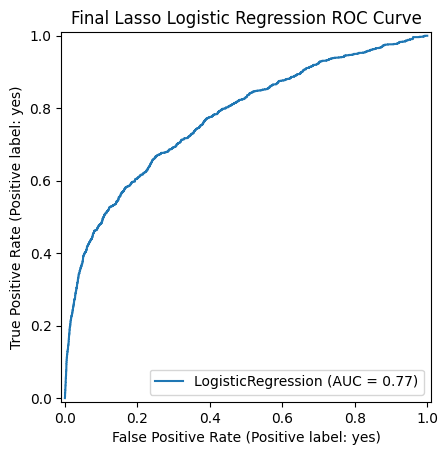

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Get the optimal C value and selected features from previous steps
# optimal_C is defined in cell bbb95061, selected_features.index is defined in jU2_MPw1E8q5

# Ensure optimal_C is defined, if not, get it from lasso_log_reg
if 'optimal_C' not in globals():
    optimal_C = lasso_log_reg.C_[0]

# Ensure selected_feature_names is defined
if 'selected_feature_names' not in globals():
    selected_feature_names = selected_features.index.tolist()

# Filter X_train and X_test to include only the selected features
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Initialize Logistic Regression model with the optimal C value and balanced class weight
final_lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=optimal_C,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# Train the model on the training data with selected features
final_lasso_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_final_lasso = final_lasso_model.predict(X_test_selected)
y_proba_final_lasso = final_lasso_model.predict_proba(X_test_selected)[:, 1]

# Evaluate the model
print("Final Lasso Logistic Regression Model Evaluation (with selected features and optimal C):")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final_lasso))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final_lasso))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba_final_lasso))

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(final_lasso_model, X_test_selected, y_test)
plt.title('Final Lasso Logistic Regression ROC Curve')
plt.show()

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# Get the optimal C value from the previously fitted lasso_log_reg
optimal_C = lasso_log_reg.C_[0]

# Get the names of the features selected by Lasso regularization
selected_feature_names = selected_features.index.tolist()

# Filter X_train to include only the selected features
X_train_selected = X_train[selected_feature_names]

# Initialize Logistic Regression model with the optimal C value and balanced class weight
model_for_cv = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=optimal_C,
    class_weight='balanced',
    max_iter=1000
)

# Perform 5-fold stratified cross-validation
# The target variable 'y_train' is used for stratification
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = cross_val_score(
    model_for_cv,
    X_train_selected,
    y_train,
    cv=stratified_kfold,
    scoring='roc_auc',
    n_jobs=-1 # Use all available CPU cores
)

print(f"ROC-AUC scores for each fold: {roc_auc_scores}")
print(f"Mean ROC-AUC: {np.mean(roc_auc_scores):.3f}")
print(f"Standard Deviation of ROC-AUC: {np.std(roc_auc_scores):.3f}")

ROC-AUC scores for each fold: [0.76703003 0.76613138 0.7616371  0.76916376 0.7618976 ]
Mean ROC-AUC: 0.765
Standard Deviation of ROC-AUC: 0.003


/tmp/ipython-input-2388136085.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=important_coefs.head(10).values, y=important_coefs.head(10).index, palette='viridis')


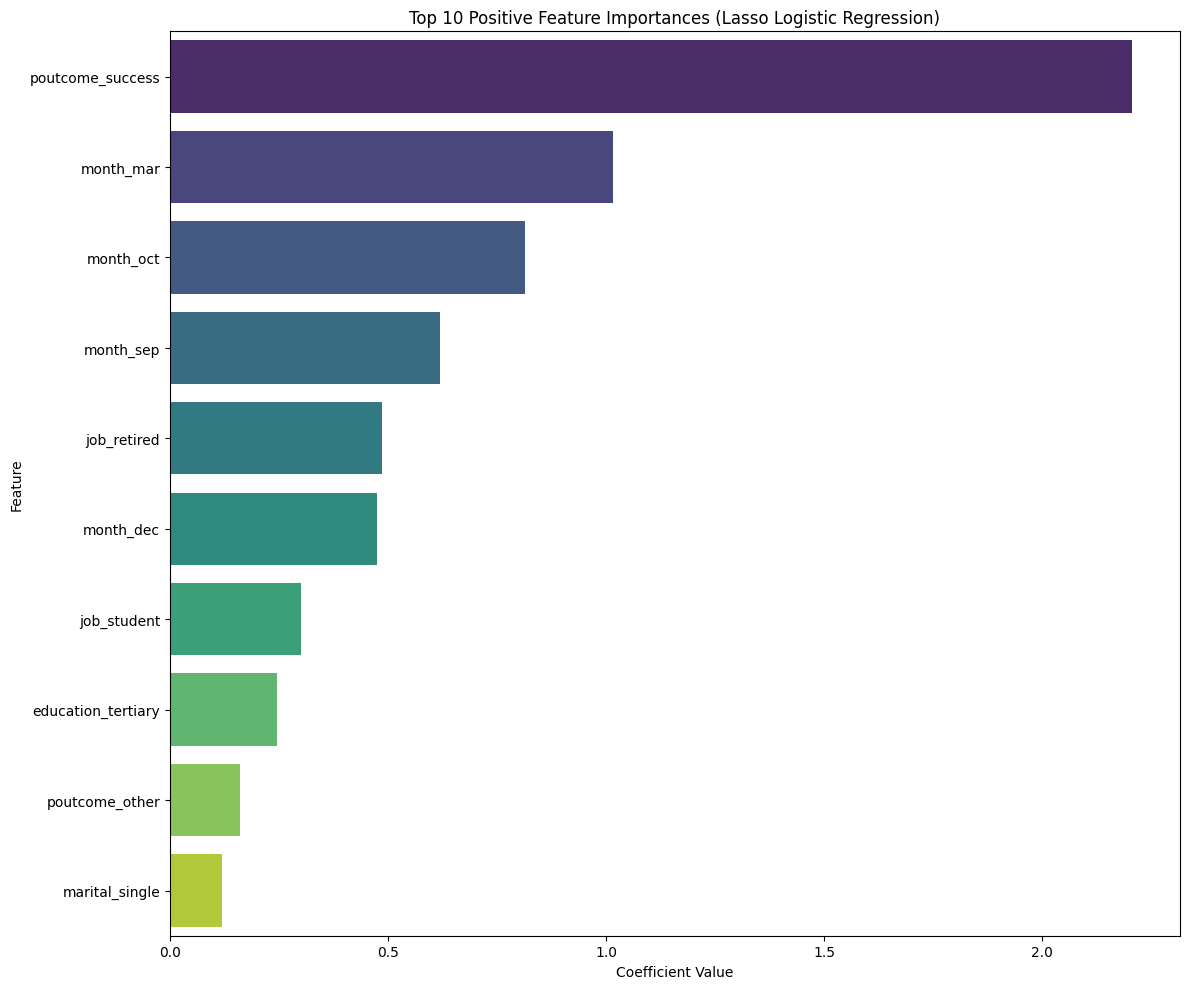

/tmp/ipython-input-2388136085.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=important_coefs.tail(10).values, y=important_coefs.tail(10).index, palette='magma')


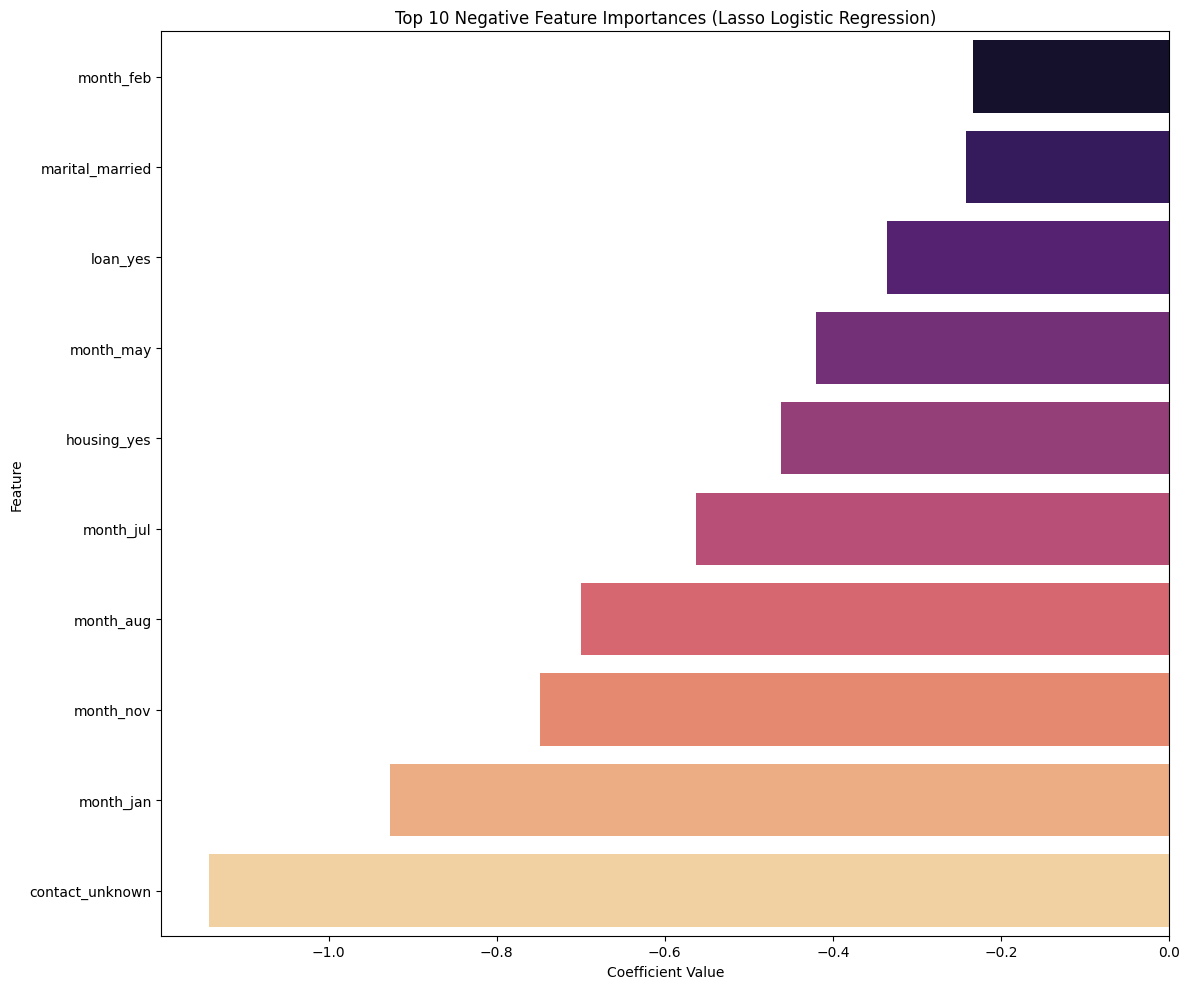

Top Positive Feature Importances (Lasso Logistic Regression):
poutcome_success      2.205798
month_mar             1.016079
month_oct             0.815049
month_sep             0.619588
job_retired           0.486824
month_dec             0.474635
job_student           0.300541
education_tertiary    0.246244
poutcome_other        0.159864
marital_single        0.119873
dtype: float64

Top Negative Feature Importances (Lasso Logistic Regression):
month_feb         -0.233335
marital_married   -0.241940
loan_yes          -0.335584
month_may         -0.419735
housing_yes       -0.461986
month_jul         -0.562427
month_aug         -0.699433
month_nov         -0.748030
month_jan         -0.927432
contact_unknown   -1.141839
dtype: float64


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get coefficients from the Lasso Logistic Regression model
# lasso_log_reg was trained on X_train, so we use X_train.columns for feature names
coefs = pd.Series(lasso_log_reg.coef_[0], index=X_train.columns)

# Filter out zero coefficients (features removed by Lasso)
important_coefs = coefs[coefs != 0].sort_values(ascending=False)

# Plot the top N positive and negative features (e.g., top 10 each)
plt.figure(figsize=(12, 10))
sns.barplot(x=important_coefs.head(10).values, y=important_coefs.head(10).index, palette='viridis')
plt.title('Top 10 Positive Feature Importances (Lasso Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.barplot(x=important_coefs.tail(10).values, y=important_coefs.tail(10).index, palette='magma')
plt.title('Top 10 Negative Feature Importances (Lasso Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Top Positive Feature Importances (Lasso Logistic Regression):")
print(important_coefs.head(10))

print("\nTop Negative Feature Importances (Lasso Logistic Regression):")
print(important_coefs.tail(10))

# Random Forest

Random Forest Model Evaluation:
Confusion Matrix:
 [[7878  107]
 [ 843  215]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.67      0.20      0.31      1058

    accuracy                           0.89      9043
   macro avg       0.79      0.59      0.63      9043
weighted avg       0.88      0.89      0.87      9043


ROC-AUC Score: 0.792715429331698


<Figure size 800x600 with 0 Axes>

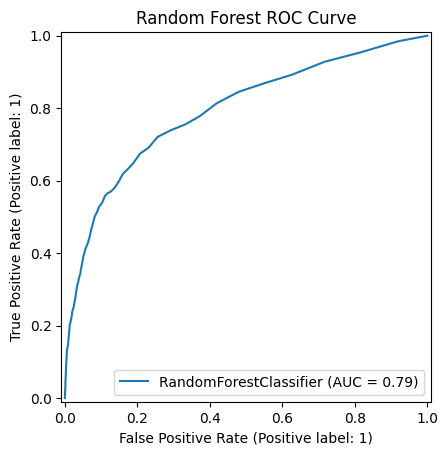

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming X and y are already defined and preprocessed from previous steps
# X contains features, y contains the target variable

# Train-test split (re-using the original X, y before scaling for LR)
X_rf = data.drop('y', axis=1)
y_rf = data['y'].map({'yes': 1, 'no': 0})

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

# Initialize and train the Random Forest Classifier
# Using class_weight='balanced' to handle potential class imbalance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_classifier.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_rf = rf_classifier.predict(X_test_rf)
y_proba_rf = rf_classifier.predict_proba(X_test_rf)[:, 1]

# Evaluation
print("Random Forest Model Evaluation:")
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_rf))
print("\nROC-AUC Score:", roc_auc_score(y_test_rf, y_proba_rf))

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_classifier, X_test_rf, y_test_rf)
plt.title('Random Forest ROC Curve')
plt.show()

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 600}
Best CV ROC-AUC: 0.7934352837813735

Tuned Random Forest Model Evaluation:
Confusion Matrix:
 [[7198  787]
 [ 475  583]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      7985
           1       0.43      0.55      0.48      1058

    accuracy                           0.86      9043
   macro avg       0.68      0.73      0.70      9043
weighted avg       0.88      0.86      0.87      9043


ROC-AUC Score: 0.8027561128912551


<Figure size 800x600 with 0 Axes>

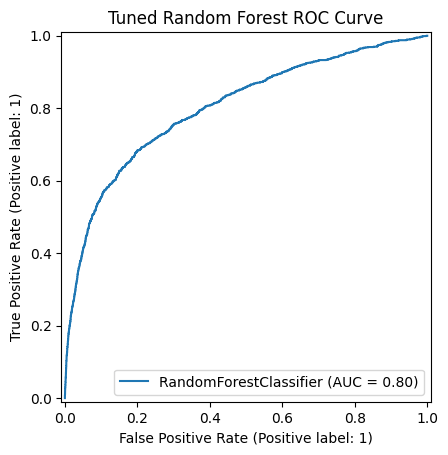

In [24]:
from sklearn.model_selection import GridSearchCV

# Initialize
# Base model
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


param_grid = {
    "n_estimators": [300, 600],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt", 0.5]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# Fit tuning on training set
grid.fit(X_train_rf, y_train_rf)

print("Best parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

best_rf = grid.best_estimator_

# Test evaluation
y_proba_rf = best_rf.predict_proba(X_test_rf)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

print("\nTuned Random Forest Model Evaluation:")
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_rf))
print("\nROC-AUC Score:", roc_auc_score(y_test_rf, y_proba_rf))

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_rf, X_test_rf, y_test_rf)
plt.title("Tuned Random Forest ROC Curve")
plt.show()

In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Get the best parameters from the GridSearchCV object
best_rf_params = grid.best_params_

# Initialize RandomForestClassifier with the best parameters and class_weight
rf_cv_model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    **best_rf_params
)

# Initialize StratifiedKFold for 5-fold cross-validation
stratified_kfold_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get ROC-AUC scores
rf_roc_auc_scores_cv = cross_val_score(
    rf_cv_model,
    X_train_rf,
    y_train_rf,
    cv=stratified_kfold_rf,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"Random Forest ROC-AUC scores for each fold (with best parameters): {rf_roc_auc_scores_cv}")
print(f"Mean Random Forest ROC-AUC (with best parameters): {np.mean(rf_roc_auc_scores_cv):.3f}")
print(f"Standard Deviation of Random Forest ROC-AUC (with best parameters): {np.std(rf_roc_auc_scores_cv):.3f}")

Random Forest ROC-AUC scores for each fold (with best parameters): [0.79874018 0.79669475 0.79338695 0.78958201 0.79207118]
Mean Random Forest ROC-AUC (with best parameters): 0.794
Standard Deviation of Random Forest ROC-AUC (with best parameters): 0.003


# XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [22:48:13] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Evaluation:
Confusion Matrix:
 [[6858 1127]
 [ 436  622]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      7985
           1       0.36      0.59      0.44      1058

    accuracy                           0.83      9043
   macro avg       0.65      0.72      0.67      9043
weighted avg       0.87      0.83      0.84      9043


ROC-AUC Score: 0.77590934325111


<Figure size 800x600 with 0 Axes>

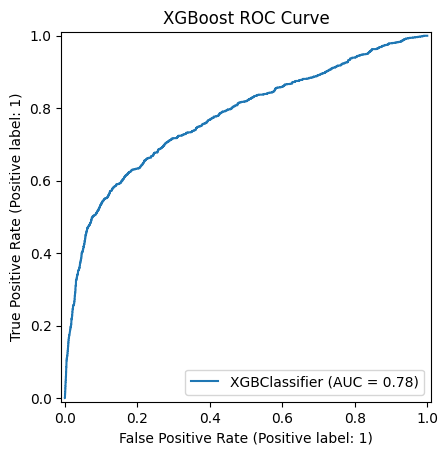

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Re-using the X_rf and y_rf data split from the Random Forest section
# XGBoost works best with numerical labels (0 and 1), which y_rf already is.

# Initialize and train the XGBoost Classifier
# Use 'scale_pos_weight' for handling imbalanced classes, calculated as count(negative_examples) / count(positive_examples)
neg_count = (y_train_rf == 0).sum()
pos_count = (y_train_rf == 1).sum()
scale_pos_weight_value = neg_count / pos_count

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_value # Handle class imbalance
)
xgb_classifier.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_xgb = xgb_classifier.predict(X_test_rf)
y_proba_xgb = xgb_classifier.predict_proba(X_test_rf)[:, 1]

# Evaluation
print("XGBoost Model Evaluation:")
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_xgb))
print("\nROC-AUC Score:", roc_auc_score(y_test_rf, y_proba_xgb))

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(xgb_classifier, X_test_rf, y_test_rf)
plt.title('XGBoost ROC Curve')
plt.show()

In [27]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# scale_pos_weight (neg/pos) from your training set
neg_count = (y_train_rf == 0).sum()
pos_count = (y_train_rf == 1).sum()
scale_pos_weight_value = neg_count / pos_count

# Base XGBoost model
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_value,
    tree_method="hist"  # faster on most machines
)

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Small, fast grid (24 combos -> 120 fits)
param_grid = {
    "n_estimators": [300, 600],
    "learning_rate": [0.03, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5]
}

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# Fit on training set
grid.fit(X_train_rf, y_train_rf)

print("Best parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

best_xgb = grid.best_estimator_

# Test evaluation
y_proba_xgb = best_xgb.predict_proba(X_test_rf)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

print("\nTuned XGBoost Model Evaluation (Test Set):")
print("ROC-AUC Score:", roc_auc_score(y_test_rf, y_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_xgb))


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
Best CV ROC-AUC: 0.799401410308754

Tuned XGBoost Model Evaluation (Test Set):
ROC-AUC Score: 0.805201269393345
Confusion Matrix:
 [[6689 1296]
 [ 371  687]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      7985
           1       0.35      0.65      0.45      1058

    accuracy                           0.82      9043
   macro avg       0.65      0.74      0.67      9043
weighted avg       0.88      0.82      0.84      9043



In [28]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Assuming best_xgb is the best estimator found by GridSearchCV in the previous cell

# Initialize StratifiedKFold for 5-fold cross-validation
stratified_kfold_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get ROC-AUC scores
xgb_roc_auc_scores_cv = cross_val_score(
    best_xgb,
    X_train_rf,  # Use the training data used for the GridSearchCV
    y_train_rf,
    cv=stratified_kfold_xgb,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"XGBoost ROC-AUC scores for each fold (with best parameters): {xgb_roc_auc_scores_cv}")
print(f"Mean XGBoost ROC-AUC (with best parameters): {np.mean(xgb_roc_auc_scores_cv):.3f}")
print(f"Standard Deviation of XGBoost ROC-AUC (with best parameters): {np.std(xgb_roc_auc_scores_cv):.3f}")

XGBoost ROC-AUC scores for each fold (with best parameters): [0.80274443 0.80130917 0.79862588 0.79857283 0.79693802]
Mean XGBoost ROC-AUC (with best parameters): 0.800
Standard Deviation of XGBoost ROC-AUC (with best parameters): 0.002


# Light GBM

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
LightGBM Model Evaluation:
Confusion Matrix:
 [[6779 1206]
 [ 378  680]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      7985
           1       0.36      0.64      0.46      1058

    accuracy                           0.82      9043
   macro avg       0.65      0.75      0.68      9043
weighted avg       0.88      0.82      0.84      9043


ROC-AUC Score: 0.8

<Figure size 800x600 with 0 Axes>

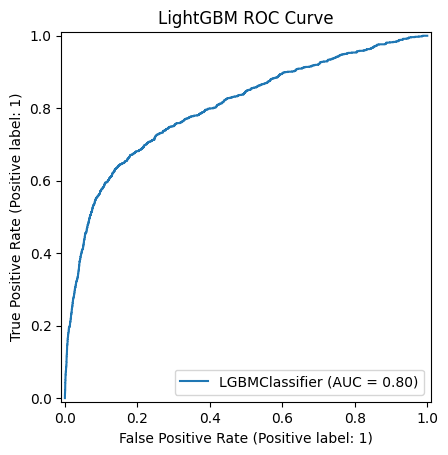

In [29]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Re-using the X_rf and y_rf data split from previous sections
# LightGBM works best with numerical labels (0 and 1), which y_rf already is.

# Calculate scale_pos_weight for handling class imbalance
neg_count = (y_train_rf == 0).sum()
pos_count = (y_train_rf == 1).sum()
scale_pos_weight_value = neg_count / pos_count

# Initialize and train the LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(
    objective='binary',               # Binary classification
    metric='binary_logloss',          # Evaluation metric
    random_state=42,                  # For reproducibility
    n_jobs=-1,                        # Use all available cores
    scale_pos_weight=scale_pos_weight_value # Handle class imbalance
)
lgb_classifier.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_lgb = lgb_classifier.predict(X_test_rf)
y_proba_lgb = lgb_classifier.predict_proba(X_test_rf)[:, 1]

# Evaluation
print("LightGBM Model Evaluation:")
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_lgb))
print("\nROC-AUC Score:", roc_auc_score(y_test_rf, y_proba_lgb))

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(lgb_classifier, X_test_rf, y_test_rf)
plt.title('LightGBM ROC Curve')
plt.show()

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

<Figure size 800x600 with 0 Axes>

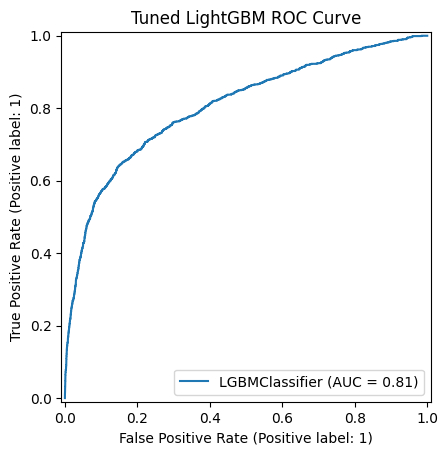

In [30]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# 1) scale_pos_weight for class imbalance
neg_count = (y_train_rf == 0).sum()
pos_count = (y_train_rf == 1).sum()
scale_pos_weight_value = neg_count / pos_count

# 2) Base model
lgbm = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_value
)

# 3) Stratified 3-fold CV (better for imbalanced data)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 4) grid (keeps runtime manageable)
param_grid = {
    "n_estimators": [300, 600],        # keep small
    "learning_rate": [0.03, 0.05],     # common good range
    "max_depth": [-1, 6],              # -1 means no limit
    "num_leaves": [31, 63],            # typical values
    "min_child_samples": [20, 50],     # regularization
}


grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# 5) Fit grid search
grid_search_lgbm.fit(X_train_rf, y_train_rf)

print("Best parameters found by GridSearchCV:", grid_search_lgbm.best_params_)
print("Best CV ROC-AUC:", grid_search_lgbm.best_score_)

# 6) Best model already refit on full training data
best_lgbm_model = grid_search_lgbm.best_estimator_

# 7) Evaluate on test set
y_proba_lgbm_tuned = best_lgbm_model.predict_proba(X_test_rf)[:, 1]
y_pred_lgbm_tuned = (y_proba_lgbm_tuned >= 0.5).astype(int)

print("\nConfusion Matrix (Tuned LightGBM):\n", confusion_matrix(y_test_rf, y_pred_lgbm_tuned))
print("\nClassification Report (Tuned LightGBM):\n", classification_report(y_test_rf, y_pred_lgbm_tuned))
print("\nROC-AUC Score (Tuned LightGBM):", roc_auc_score(y_test_rf, y_proba_lgbm_tuned))

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_lgbm_model, X_test_rf, y_test_rf)
plt.title("Tuned LightGBM ROC Curve")
plt.show()

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
import numpy as np

# Best parameters found by GridSearchCV (provided by user)
best_params = {
    'learning_rate': 0.03,
    'max_depth': 6,
    'min_child_samples': 50,
    'n_estimators': 300,
    'num_leaves': 63
}

# Calculate scale_pos_weight for handling class imbalance
neg_count = (y_train_rf == 0).sum()
pos_count = (y_train_rf == 1).sum()
scale_pos_weight_value = neg_count / pos_count

# Initialize LGBMClassifier with the best parameters
lgbm_cv_model = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_value,
    **best_params
)

# Initialize StratifiedKFold for 5-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get ROC-AUC scores
lgbm_roc_auc_scores_cv = cross_val_score(
    lgbm_cv_model,
    X_train_rf,
    y_train_rf,
    cv=stratified_kfold,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"LightGBM ROC-AUC scores for each fold (with specified parameters): {lgbm_roc_auc_scores_cv}")
print(f"Mean LightGBM ROC-AUC (with specified parameters): {np.mean(lgbm_roc_auc_scores_cv):.3f}")
print(f"Standard Deviation of LightGBM ROC-AUC (with specified parameters): {np.std(lgbm_roc_auc_scores_cv):.3f}")

LightGBM ROC-AUC scores for each fold (with specified parameters): [0.79949116 0.79754991 0.79343954 0.79356219 0.7972296 ]
Mean LightGBM ROC-AUC (with specified parameters): 0.796
Standard Deviation of LightGBM ROC-AUC (with specified parameters): 0.002


## SHAP Feature Importance for LightGBM

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


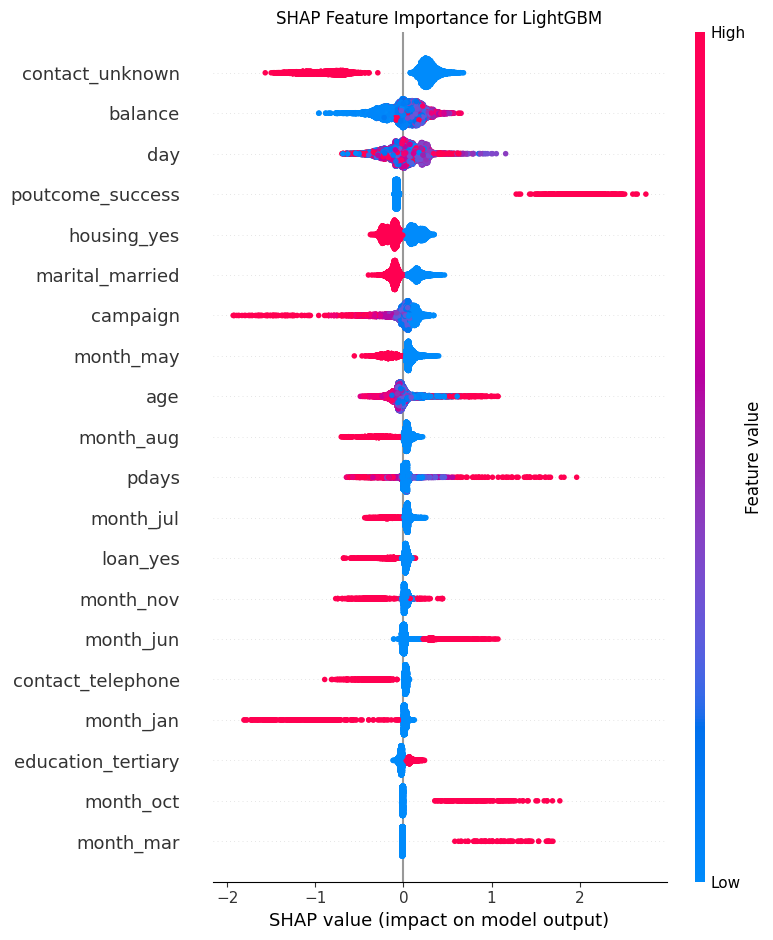

In [32]:
import shap
import matplotlib.pyplot as plt

# Ensure the LightGBM model is trained (lgb_classifier or best_lgbm_model if tuned)
# We'll use the 'best_lgbm_model' from the GridSearchCV for the most optimized results

# Calculate scale_pos_weight for handling class imbalance (if not already defined)
if 'scale_pos_weight_value' not in globals():
    neg_count = (y_train_rf == 0).sum()
    pos_count = (y_train_rf == 1).sum()
    scale_pos_weight_value = neg_count / pos_count

# Initialize LGBMClassifier with the best parameters (from previous GridSearchCV cell)
best_params = {
    'learning_rate': 0.03,
    'max_depth': 6,
    'min_child_samples': 50,
    'n_estimators': 300,
    'num_leaves': 63
}

# Re-initialize and train the best LGBM model to ensure it's available
# (in case the notebook was run partially and best_lgbm_model wasn't set globally)
shap_lgbm_model = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_value,
    **best_params
)
shap_lgbm_model.fit(X_train_rf, y_train_rf)

# Create a SHAP explainer object
# For tree-based models, TreeExplainer is efficient
explainer = shap.TreeExplainer(shap_lgbm_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_rf)

# Plot summary of SHAP values (Feature Importance)
# Changed from shap_values[1] to shap_values as it's already a 2D array for the positive class
shap.summary_plot(shap_values, X_test_rf, show=False)
plt.title('SHAP Feature Importance for LightGBM')
plt.tight_layout()
plt.show()


# Neural Networks

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8746 - loss: 0.3533 - val_accuracy: 0.8913 - val_loss: 0.2995
Epoch 2/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8934 - loss: 0.3055 - val_accuracy: 0.8929 - val_loss: 0.3007
Epoch 3/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8935 - loss: 0.2991 - val_accuracy: 0.8933 - val_loss: 0.2909
Epoch 4/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8910 - loss: 0.3002 - val_accuracy: 0.8941 - val_loss: 0.2923
Epoch 5/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8935 - loss: 0.2924 - val_accuracy: 0.8938 - val_loss: 0.2920
Epoch 6/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8946 - loss: 0.2884 - val_accuracy: 0.8944 - val_loss: 0.2912
Epoch 7/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8971 - loss: 0.2839 - val_accuracy: 0.8947 - val_loss: 0.2922
Epoch 8/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8949 - loss: 0.2851 - val_accuracy: 0.

<Figure size 800x600 with 0 Axes>

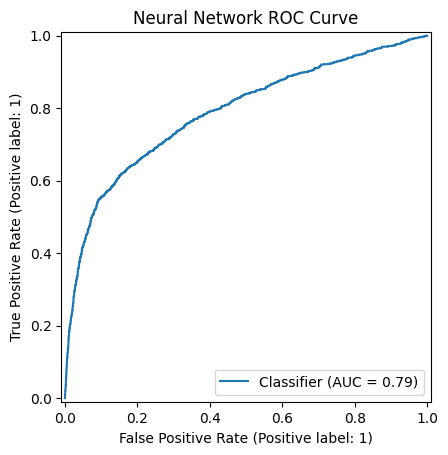

In [33]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Prepare data for Neural Network (ensure X and y are numeric and scaled)
# Reuse X_rf and y_rf which are already set up with 0/1 target
X_nn = X_rf.copy()
y_nn = y_rf.copy()

# Scale numerical features for Neural Network
# Identify numerical columns in X_nn (which is currently X_rf with boolean Dtypes after one-hot encoding)
numeric_cols_nn = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
scaler_nn = StandardScaler()
X_nn[numeric_cols_nn] = scaler_nn.fit_transform(X_nn[numeric_cols_nn])

# Convert boolean columns to integer (0 or 1) for Keras compatibility
for col in X_nn.select_dtypes(include='bool').columns:
    X_nn[col] = X_nn[col].astype(int)

# Train-test split for Neural Network
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=42, stratify=y_nn
)

# Define the Neural Network model
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_train_nn.shape[1],)), # Input layer matching number of features
    keras.layers.Dense(128, activation='relu'), # Hidden layer with 128 neurons and ReLU activation
    keras.layers.Dropout(0.3), # Dropout for regularization
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons and ReLU activation
    keras.layers.Dropout(0.3), # Dropout for regularization
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification (sigmoid activation)
])

# Compile the model
# Using Adam optimizer and binary crossentropy for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_nn,
    y_train_nn,
    epochs=20, # Number of training epochs
    batch_size=32, # Batch size for training
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1 # Show training progress
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_nn, y_test_nn, verbose=0)
print(f"\nNeural Network Test Loss: {loss:.4f}")
print(f"Neural Network Test Accuracy: {accuracy:.4f}")

y_pred_nn_proba = model.predict(X_test_nn).ravel()
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)

# Evaluation Metrics
print("\nNeural Network Model Evaluation:")
print("Confusion Matrix:\n", confusion_matrix(y_test_nn, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test_nn, y_pred_nn))
print("\nROC-AUC Score:", roc_auc_score(y_test_nn, y_pred_nn_proba))

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test_nn, y_pred_nn_proba)
plt.title('Neural Network ROC Curve')
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_plotting.py:176: FutureWa

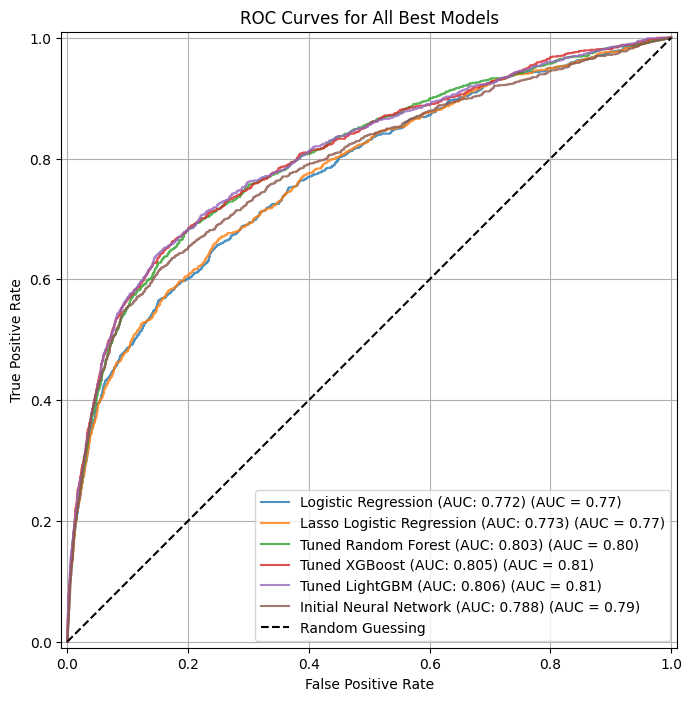

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Prepare data for plotting
roc_data = [
    {
        'name': f"Logistic Regression (AUC: {roc_auc_score(y_test_rf, y_proba):.3f})",
        'y_true': y_test_rf,
        'y_proba': y_proba
    },
    {
        'name': f"Lasso Logistic Regression (AUC: {roc_auc_score(y_test_rf, y_proba_final_lasso):.3f})",
        'y_true': y_test_rf,
        'y_proba': y_proba_final_lasso
    },
    {
        'name': f"Tuned Random Forest (AUC: {roc_auc_score(y_test_rf, y_proba_rf):.3f})",
        'y_true': y_test_rf,
        'y_proba': y_proba_rf
    },
    {
        'name': f"Tuned XGBoost (AUC: {roc_auc_score(y_test_rf, y_proba_xgb):.3f})",
        'y_true': y_test_rf,
        'y_proba': y_proba_xgb
    },
    {
        'name': f"Tuned LightGBM (AUC: {roc_auc_score(y_test_rf, y_proba_lgbm_tuned):.3f})",
        'y_true': y_test_rf,
        'y_proba': y_proba_lgbm_tuned
    },
    {
        'name': f"Initial Neural Network (AUC: {roc_auc_score(y_test_nn, y_pred_nn_proba):.3f})",
        'y_true': y_test_nn,
        'y_proba': y_pred_nn_proba
    }
]

plt.figure(figsize=(10, 8))
ax = plt.gca()

for i, data in enumerate(roc_data):
    RocCurveDisplay.from_predictions(
        data['y_true'],
        data['y_proba'],
        name=data['name'],
        ax=ax,
        alpha=0.8
    )

plt.title('ROC Curves for All Best Models')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
